# Lesson 2: Chain-of-Thought and ReACT Prompting

## Demand‑Spike Detective, Part I: Chain-of-Thoughts

In this hands-on exercise, you will guide an LLM to explain an unexpected sales spike.

### Outline:
- Setup
- Understand sales data, promotional calendars, etc. 
- Craft a Simple CoT prompt
- Craft a More Developed CoT Prompt

## 1. Setup

Let's start by setting up the environment.

In [8]:
# Import necessary libraries
# No changes needed in this cell

import os

import pandas as pd
from IPython.display import Markdown, display
from lesson_2_lib import (
    # Helpers
    OpenAIModels,
    display_responses,
    # Synthetic data
    get_competitor_pricing_data,
    get_completion,
    get_promotions_data,
    get_sales_data,
    get_weather_data,
)
from openai import OpenAI

MODEL = OpenAIModels.GPT_41_NANO


In [ ]:
# If using the Vocareum API endpoint
# No changes needed in this cell
# TODO: Fill in the missing parts marked with **********

client = OpenAI(
    base_url="https://openai.vocareum.com/v1",
    # Uncomment one of the following
    # api_key="**********",  # <--- TODO: Fill in your Vocareum API key here
    # api_key=os.getenv(
    #     "OPENAI_API_KEY"
    # ),  # <-- Alternately, set as an environment variable (more secure)
)

# If using OpenAI's API endpoint
# client = OpenAI()


## 2. Understand sales data, promotional calendars, etc.

First, let's review the sample data provided. Working with AI Agents is still a data problem at its core, so the first steps are always to understand the business goals (explain the cause for the spike) and the underlying data.

In [10]:
# View the data
get_sales_data()[:3]

[{'date': datetime.date(2024, 1, 10),
  'product_id': 'P001',
  'product_name': 'Product 1',
  'quantity': 255,
  'revenue': 15547.35},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P002',
  'product_name': 'Product 2',
  'quantity': 65,
  'revenue': 2297.1},
 {'date': datetime.date(2024, 1, 10),
  'product_id': 'P003',
  'product_name': 'Product 3',
  'quantity': 90,
  'revenue': 7301.7}]

In [11]:
# Load the simulated data
# No changes needed in this cell

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

sales_data = get_sales_data()
sales_df = pd.DataFrame(sales_data)

promotions_data = get_promotions_data()
promotions_df = pd.DataFrame(promotions_data)

weather_data = get_weather_data()
weather_df = pd.DataFrame(weather_data)

competitor_pricing_data = get_competitor_pricing_data()
competitor_pricing_df = pd.DataFrame(competitor_pricing_data)


In [12]:
# Show the sales data
# No changes needed in this cell

sales_df = sales_df.sort_values(by=["product_id", "date"]).reset_index(drop=True)
sales_df


,date,product_id,product_name,quantity,revenue
0,2024-01-10,P001,Product 1,255,15547.35
1,2024-01-11,P001,Product 1,235,14327.95
2,2024-01-12,P001,Product 1,310,18900.70
3,2024-01-13,P001,Product 1,302,18412.94
4,2024-01-14,P001,Product 1,305,18595.85
5,2024-01-15,P001,Product 1,301,18351.97
6,2024-01-16,P001,Product 1,226,13779.22
7,2024-01-10,P002,Product 2,65,2297.10
8,2024-01-11,P002,Product 2,86,3039.24
9,2024-01-12,P002,Product 2,80,2827.20


In [13]:
# Show the promotions data
# No changes needed in this cell

promotions_df

,promotion_id,name,discount,products,start_date,end_date
0,PROMO001,Weekend Special,10% off,[P002],2024-01-12,2024-01-14
1,PROMO002,Flash Sale,15% off,"[P001, P003, P005]",2024-01-15,2024-01-16


In [14]:
# Show the weather data
# No changes needed in this cell

weather_df.head()

,date,temperature,conditions
0,2024-01-10,"{'fahrenheit': 23.4, 'celsius': -4.8}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
1,2024-01-11,"{'fahrenheit': 39.3, 'celsius': 4.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
2,2024-01-12,"{'fahrenheit': 41.1, 'celsius': 5.1}","{'main': 'Heavy Rain', 'precipitation': 'Heavy Rain', 'precipitation_amount': 2.7, 'special_event': 'Flood Warning'}"
3,2024-01-13,"{'fahrenheit': 27.2, 'celsius': -2.6}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"
4,2024-01-14,"{'fahrenheit': 22.9, 'celsius': -5.1}","{'main': 'Clear', 'precipitation': 'None', 'precipitation_amount': 0, 'special_event': None}"


In [15]:
# Show the competitor pricing data
# No changes needed in this cell

competitor_pricing_df

,product,date,our_price,competitor_sales,competitor_a_price,competitor_b_price,competitor_c_price
0,Product 1,2024-01-10,60.97,{},56.88,62.23,51.80
1,Product 1,2024-01-11,60.97,{},59.65,72.47,72.50
2,Product 1,2024-01-12,60.97,"{'CompetitorB': {'original_price': 69.24, 'sale_price': 50.55, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 49.92, 'sale_price': 39.44, 'discount_percentage': 21}}",65.40,50.55,39.44
3,Product 1,2024-01-13,60.97,{},72.13,57.54,51.10
4,Product 1,2024-01-14,60.97,{},72.36,70.04,61.04
5,Product 1,2024-01-15,60.97,{},68.52,59.63,73.03
6,Product 1,2024-01-16,60.97,"{'CompetitorA': {'original_price': 53.84, 'sale_price': 44.69, 'discount_percentage': 17}}",44.69,57.69,70.51
7,Product 2,2024-01-10,35.34,{},34.57,42.01,42.02
8,Product 2,2024-01-11,35.34,"{'CompetitorB': {'original_price': 40.13, 'sale_price': 29.29, 'discount_percentage': 27}, 'CompetitorC': {'original_price': 28.93, 'sale_price': 22.85, 'discount_percentage': 21}}",37.91,29.29,22.85
9,Product 2,2024-01-12,35.34,{},41.81,33.35,29.62


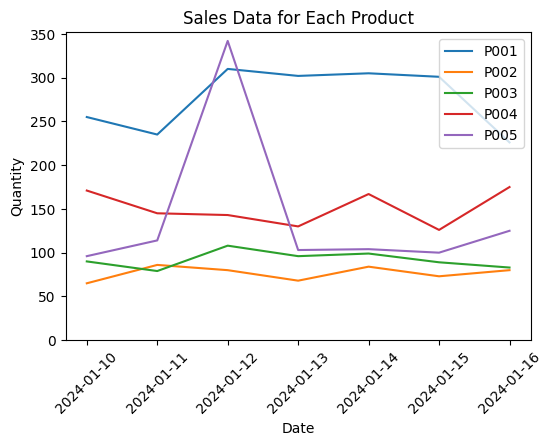

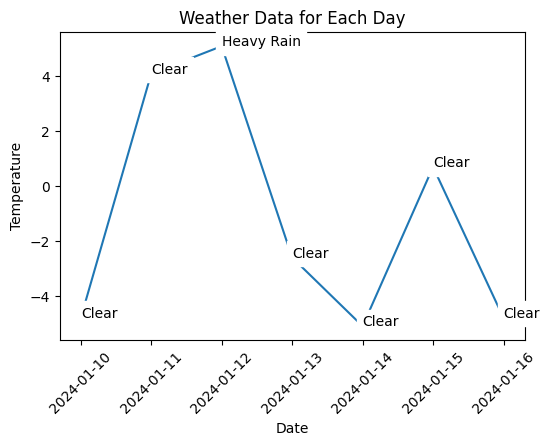

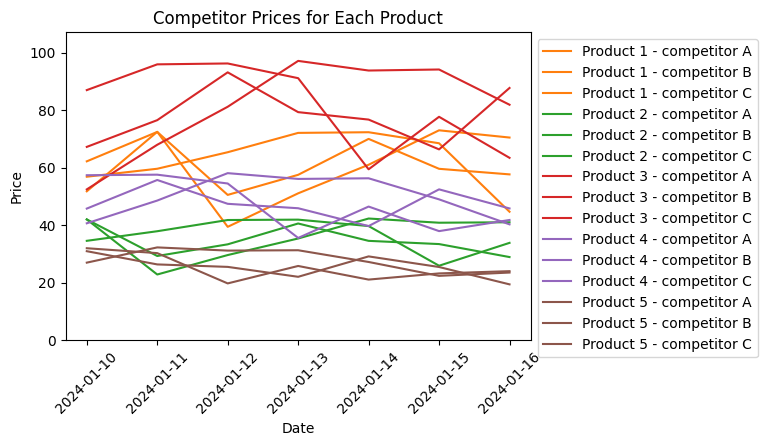

In [17]:
# Graph the sales data
# No changes needed in this cell

import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
for product_id, product_data in sales_df.groupby("product_id"):
    product_data.sort_values(by="date", inplace=True)
    plt.plot(product_data["date"], product_data["quantity"], label=product_id)
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title("Sales Data for Each Product")
plt.xticks(rotation=45)
plt.ylim(0, sales_df["quantity"].max() + 10)
plt.legend()
plt.show()

# Plot the weather data

weather_df["temperature_c"] = weather_df["temperature"].apply(lambda x: x["celsius"])


plt.figure(figsize=(6, 4))
plt.plot(weather_df["date"], weather_df["temperature_c"])

# For each day, add the value of "main" in text
for i, row in weather_df.iterrows():
    # Add a transparent background to the text
    plt.text(
        row["date"],
        row["temperature_c"],
        row["conditions"]["main"],
        backgroundcolor="white",
    )


plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Temperature")
plt.title("Weather Data for Each Day")
plt.show()

# Plot the competitor pricing data

plt.figure(figsize=(6, 4))
for product in competitor_pricing_df["product"].unique():
    for competitor in ["a", "b", "c"]:
        plt.plot(
            competitor_pricing_df[competitor_pricing_df["product"] == product]["date"],
            competitor_pricing_df[competitor_pricing_df["product"] == product][
                f"competitor_{competitor}_price"
            ],
            label=f"{product} - competitor {competitor.upper()}",
            color=f"C{product[-1]}",
        )
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.ylabel("Price")
plt.ylim(0, competitor_pricing_df.filter(like="price").max().max() + 10)
plt.title("Competitor Prices for Each Product")
# Put the legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

### Reflect on the sales data

`TODO: Insert your reflection here`

Reflection:

* Sales spike for Product 5 on January 12th
* The "Weekend Special" promotion which started on January 12th, but that was for Product 2. Still, it may have had an indirect effect on Product 5.
* Weather was fluctuating between below freezing and above freezing. On the 12th in particular, there was heavy rain.
* As for Competitor pricing, we see that Product 5's price for one competitor dropped on January 12th, which may have led to more overall consumer interest in that product or may have coincided with an ad campaign.

In practice, a human would look at all these factors and more to determine the cause of the sales spike by digging deeper.

Let's see if we can get this far with a CoT prompt, which should at least find the sales spike and provide some reasons similar to what we've observed as human beings.

## 3. Craft a simple CoT prompt

Let's start with a simple CoT prompt. We won't tell the model to which steps to follow. We also won't use any tools in this example.

<div style="color: red">Note: Many modern LLMs may not need an explicit "think in steps" phrase in order to think in steps before providing an answer, as this behavior can be included in training process. Consider running your prompts with and without asking for CoT explicitly. In fact, multiple runs may yield different results, so it's worth simply re-running the same prompts more than once.</div>


In [19]:
# TODO: Fill in the part marked with ********** with a phrase such as "Think step by step."
# Feel free to try variations!

system_prompt_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step.
"""

system_prompt_no_explicit_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
"""

user_prompt_analyze = f"""
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
explicit_cot_response_1 = get_completion(
    system_prompt=system_prompt_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
no_explicit_cot_response_2 = get_completion(
    system_prompt=system_prompt_no_explicit_cot, user_prompt=user_prompt_analyze,
    model=MODEL,
    client=client
)
print("Response received!\n")

# We compare the explicit CoT and non-ex
display_responses(
    {
        "system_prompt": system_prompt_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": explicit_cot_response_1,
    },
    {
        "system_prompt": system_prompt_no_explicit_cot,
        "user_prompt": user_prompt_analyze,
        "response": no_explicit_cot_response_2,
    },
)


Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



<table><tr><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think step by step.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2... [truncated]</th><th>System Prompt:<br />
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.
<br /><br />User Prompt:<br />
Analyze the data provided below and hypothesize causes for any observed sales spikes.

Sales Data:
[{'date': datetime.date(2024, 1, 10), 'product_id': 'P001', 'product_name': 'Product 1', 'quantity': 255, 'revenue': 15547.35}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P002', 'product_name': 'Product 2', 'quantity': 65, 'revenue': 2297.1}, {'date': datetime.date(2024, 1, 10), 'product_id': 'P003', 'product_name': 'Product 3', 'quantity': 90, 'revenue': 7301.7}, {'date': datetime.date(2... [truncated]</th></tr><tr><td>Response:<br />Let's analyze the data step-by-step to identify and hypothesize causes for the observed sales spikes.

---

### 1. **Identify Sales Spikes in the Data**

**Sales Data Highlights:**

- **January 12, 2024:**
  - *Product 1*: 310 units (highest in the week)
  - *Product 2*: 80 units
  - *Product 3*: 108 units
  - *Product 4*: 143 units
  - *Product 5*: 342 units (**highest overall units sold for Product 5**)

- **January 13, 2024:**
  - Slight decline from Jan 12, but still high sales
  - *Product 1*: 302 units
  - *Product 5*: 103 units

- **January 14, 2024:**
  - *Product 1*: 305 units
  - *Product 2*: 84 units
  - *Product 3*: 99 units
  - *Product 4*: 167 units
  - *Product 5*: 104 units

- **January 16, 2024:**
  - *Product 4*: 175 units (highest in the week)
  - *Product 5*: 125 units
  - *Product 1*: 226 units (significant increase)
  - *Product 3*: 83 units

---

### 2. **Correlation with Promotions Calendar**

**Promotion Schedule:**
- **Weekend Special (Jan 12-14):** 10% off on *Product 002*.
- **Flash Sale (Jan 15-16):** 15% off on *Products 001, 003, 005*.

**Observation:**
- The **highest sales for Product 5** (342 units) occurred on **January 12**, coinciding with the *Weekend Special* promotion for *Product 2*. Product 5 was **not under promotion** at that time.
- On **January 15-16**, during the *Flash Sale*, sales for *Products 001, 003, 005* are high but not at the peak levels seen on Jan 12.

**Hypothesis:**
- The **sales spike on Jan 12** is **not directly driven by the scheduled promotions** since *Product 5* was not included.
- The **sales increase on Jan 15-16** aligns with the *Flash Sale*, suggesting the promotion effectively boosted sales of promoted products.

### 3. **Price Analysis and Competitor Pricing**

- For **Product 5** on Jan 12:
  - Our Price: **$26.95**
  - Competitors:
    - *Competitor A*: $19.75 (sale, 21% discount)
    - *Competitor B*: $25.50
    - *Competitor C*: $31.17
  
- On Jan 12, *Competitor A* had a **sale price significantly lower ($19.75)**, yet *Product 5* sales were extremely high (342 units).  
- **Possible Causes:**
  - Customers might be stockpiling in anticipation of promotions or due to other factors.
  - The high sales could also be driven by other factors, such as seasonal demand or non-price factors like marketing campaigns not shown here.

- For **Product 1**:
  - Price remains **$60.97** across the week.
  - On Jan 12, competitor prices varied, but our price remained competitive.
  - The spike in units suggests increased demand, likely influenced by the upcoming *Flash Sale* starting Jan 15 (promotion effective from Jan 15 onward).

### 4. **Weather and External Factors**

- **Heavy Rain and Flood Warning on Jan 12**:
  - The weather on Jan 12 was **heavy rain** with a flood warning.
  - Typically, bad weather might **reduce foot traffic**, but in some cases, it can **increase demand for certain products** (e.g., home essentials, comfort items).
  - Without detailed product category data, this is speculative. But the spike in sales could be **counterintuitive** or driven by **stockpiling or online shopping**.

### 5. **Summary of Causes for Major Sales Spikes**

| Date | Products with Spikes | Potential Causes |
|---------|-------------------------|----------------------|
| **Jan 12** | *Product 5* (342 units), *Product 1* (310 units) | - Peak sales of *Product 5* possibly due to **stockpiling during adverse weather** or **non-promotional factors**. <br>- The **heavy rain and flood warning** might have pushed customers to purchase in advance or online. <br>- Sales of *Product 1* may be driven by **general demand or early anticipation of upcoming promotions**. |
| **Jan 13-14** | Consistent high sales, especially during *Promotion* period (Jan 12-14) | - Continued effects of weather or ongoing demand. |
| **Jan 15-16** | *Product 1* (226 units), *Product 5* (125 units), *Product 4* (175 units) | - The **start of the 'Flash Sale' promotion** on Jan 15-16** for *Products 001, 003, 005* appears to **drive increased sales**. <br>- Price discounts and promotion visibility likely contributed. |

---

### 6. **Final Hypotheses**

- **Primary driver of sales spikes for Jan 12** (notably for *Product 5*) appears **not directly linked to the scheduled promotions**. It could be **external factors** such as weather, customer stockpiling, or non-scheduled marketing efforts.
- The **sales surge during Jan 15-16** correlates with the **'Flash Sale' promotion**, indicating that **promotional discounts** significantly **boosted sales** for the targeted products.
- The **competitor pricing** suggests that **pricing strategies** (especially maintaining competitive prices and leveraging discounts) are **critical in influencing customer purchase behavior**.

---

### **Conclusion:**

- The notable **sales spike for Product 5 on Jan 12** seems **more associated with external factors** like weather or customer behavior rather than promotions.
- The **sales increases on Jan 15-16** are **primarily attributable to the 'Flash Sale' promotion**, as evidenced by the timing and targeted products.

---

If further data on marketing campaigns, customer feedback, or inventory levels were available, it could refine these hypotheses further.</td><td>Response:<br />Based on the sales data, promotion schedules, weather, and competitor pricing, several observations can be made regarding the significant sales spikes, particularly on January 12 and January 16, 2024.

**1. Sales Spike on January 12, 2024**

- **Observed Data:**
  - Notable increases in quantities sold for all products:
    - Product 1: 310 units (highest recorded)
    - Product 2: 108 units (highest recorded)
    - Product 3: 108 units (highest recorded)
    - Product 4: 143 units (highest recorded)
    - Product 5: 342 units (highest recorded)
  - The sales jump is most pronounced for Product 5, with 342 units sold—more than double the previous day.
  - Promotion:
    - **"Weekend Special"** with 10% off on Product 2 runs from Jan 12 to Jan 14.
  - Competitor Pricing:
    - For Product 1, a significant price drop by Competitor B (sale at 50.55, a 27% discount from 69.24) suggests a price competition.
    - Product 2: Competitors offered discounts (e.g., Competitor B at 29.29, a 27% discount).
    - Product 3: Competitor discounts (e.g., sale at 59.46, 17% off).
    - Product 4: Competitor sale at 35.57 (17% discount).
    - Product 5: Competitor A price reduced to 19.75 (17% off).
  - Weather:
    - Heavy rain and flood warning on Jan 12 likely affected shopping behavior but may also have prompted consumers to purchase in bulk or online.
  
- **Hypotheses for the Spike:**
  - The **"Weekend Special" promotion** on Product 2, Product 3, and Product 5 likely drove increased demand, especially as discounts became more attractive.
  - Competitor price reductions, particularly on Product 2 and Product 5, possibly influenced customers to purchase more.
  - Severe weather (heavy rain) might have led consumers to stay indoors, increasing online or bulk purchases.
  - The combination of promotional discounts and competitor price cuts created a compelling value proposition prompting higher sales.

---

**2. Sales Spike on January 16, 2024**

- **Observed Data:**
  - Product 1: 226 units
  - Product 2: 80 units
  - Product 3: 83 units
  - Product 4: 175 units
  - Product 5: 125 units
  - All products saw increased sales compared to prior days.
  - Promotions:
    - **"Flash Sale"** from Jan 15 to Jan 16, offering 15% off on Products 1, 3, and 5.
  - Competitor Pricing:
    - Notably, for Product 1, a competitor (Competitor A) offered a sale at 44.69 (17% discount), making our price ($60.97) less competitive but still consistent with previous days.
    - For Product 2 and 3, competitors had varied prices, sometimes with discounts.
    - For Product 4, competitors offered discounts up to 21%.
    - For Product 5, multiple competitors offered discounts (up to 23%).

- **Weather & External Factors:**
  - Clear weather with no adverse conditions.
  - The "Flash Sale" on Jan 15-16 likely stimulated urgency-driven purchases.

- **Hypotheses for the Spike:**
  - The **"Flash Sale"** offered significant discounts (15%), likely creating a sense of urgency and boosting sales.
  - Consumers taking advantage of the discount before it ended on Jan 16 contributed to the spike.
  - Competitive pricing, especially on Products 2 and 3 with discounted rival prices, may have encouraged customers to buy more.
  - No adverse weather or external disruptions likely facilitated higher in-store or online traffic during the sale.

---

**Summary of Causes for Sales Spikes:**

| Date | Main Causes |
|---------|----------------|
| Jan 12 | - Promotion ("Weekend Special" on P002, P003, P005) with 10% off<br>- Competitor discounts on similar products<br>- Severe weather (heavy rain, flood warning) possibly increasing bulk or online shopping<br>- Price competition and perceived value shifts |
| Jan 16 | - Promotion ("Flash Sale" on P001, P003, P005) with 15% off<br>- Consumer urgency due to limited-time discounts<br>- Competitive price reductions on rival products<br>- Favorable weather conditions |

**Recommendations:**
- The combined effect of targeted promotions and competitor pricing strategies significantly influences sales volumes.
- Severe weather events can amplify or dampen demand depending on whether shopping shifts online or in-store.
- Future planning should consider timing promotions around competitor activity, weather forecasts, and consumer behavior patterns to maximize impact.

**Note:** Further data over a longer period would enable more robust trend analysis, but given the current snapshot, promotional timing and competitor pricing are key drivers behind the observed sales spikes.</td></tr></table>

### Observation

- What were the differences between including CoT and not including CoT explicitly in the prompt?

## 4. Craft a More Developed CoT Prompt

Let's add more to our CoT prompt. Let's ask the model to follow a specific set of steps in an **instructions section**. This may help us not only get final answers that align with our needs, but it will also help us constrain the output to a more specific format.

Finally, we'd like to the model to identify the single largest spike and hypothesize its causes, using the following output format:

````

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}
```

````

In [21]:
# Let's add some more components to our CoT Prompt
# TODO: Replace parts marked with a **********

system_prompt_cot = """
You are a meticulous Retail Demand Analyst.
Your task is to analyze provided sales data and promotion schedules to identify and explain significant sales spikes for specific SKUs.

Think in steps.
"""

user_prompt_analyze = f"""
## INSTRUCTIONS:

Analyze the data provided below and hypothesize causes for any observed sales spikes.

Instructions:
* Find all sales spikes for each product
* For each product, identify the following:
    * Date of the sales spike
    * Amount of the sales spike and percentage increase
    * Possible causes of the sales spike according to the provided
        * sales data
        * promotion schedule
        * weather conditions
        * competitor pricing data
* Start with your analysis
* Conclude with the single largest spike according to the percentage increase with a short explanation for it.

--

## OUTPUT FORMAT:

STRUCTURED ANALYSIS:
[Structured Analysis]

LARGEST SPIKE:
```json
{{
    "date": "YYYY-MM-DD",
    "amount_before_increase": "X.XX",
    "amount_after_increase": "X.XX",
    "percentage_increase": "X.XX%",
    "causes": [
        "Cause 1",
        "Cause 2",
        "Cause 3"
    ]
}}
```

---

## CONTEXT

Sales Data:
{sales_data}

Promotions Calendar:
{promotions_data}

Weather Data:
{weather_data}

Competitor Pricing Data:
{competitor_pricing_data}
"""

print(f"Sending prompt to {MODEL} model...")
cot_response = get_completion(system_prompt=system_prompt_cot, user_prompt=user_prompt_analyze,
                              model=MODEL, client=client)
print("Response received!\n")


def parse_analysis_and_largest_spike(response):
    import json

    if "```json" not in response:
        print()
        print(response)
        raise RuntimeError(
            " ❌ No LARGEST SPIKE found in response. Looking for: \n\n```json"
        )

    analysis = response.split("```json")[0].strip()
    json_str = response.split("```json")[1].split("```")[0].strip()
    return analysis, json.loads(json_str)


analysis, largest_spike = parse_analysis_and_largest_spike(cot_response)

display(Markdown(analysis))

Sending prompt to OpenAIModels.GPT_41_NANO model...
Response received!



**STRUCTURED ANALYSIS**

---

### Product 1 (P001)
- **Sales Data:**
  - Jan 10: 255 units
  - Jan 11: 235 units
  - Jan 12: 310 units (peak)
  - Jan 13: 302 units
  - Jan 14: 305 units
  - Jan 15: 301 units
  - Jan 16: 226 units 
  
- **Observation:** The largest sales spike occurs on **2024-01-12** with 310 units, up from 235 units on Jan 11 (~31.9% increase).

- **Promotion Schedule:** No active promotion on Jan 12.

- **Weather:** Light conditions (clear, mild temperatures).

- **Competitor Pricing:** On Jan 12, our price was $60.97. Competitors' prices varied, with one competitor (Competitor B) offering a sale at $50.55 (27% discount). Our price was higher than some competitors but not the lowest.

- **Possible causes:**
  - The spike could be due to natural weekly demand increase or inventory replenishment.
  - Slightly favorable competitor pricing on Jan 12 (e.g., B’s sale) might have driven some customers, but our consistent pricing suggests internal factors are more relevant.
  - No promotion or weather anomalies correlate directly.

---

### Product 2 (P002)
- **Sales Data:**
  - Jan 10: 65
  - Jan 11: 86 (increase)
  - Jan 12: 80
  - Jan 13: 68
  - Jan 14: 84
  - Jan 15: 73
  - Jan 16: 80

- **Observation:** The highest sales occur on Jan 11 with 86 units, a 32.3% increase from Jan 10.

- **Promotion Schedule:** No active promotion.

- **Weather:** Temperatures mild, no extreme weather.

- **Competitor Pricing:**
  - Jan 11: Sale at $29.29 from competitors (27% off), making our price ($35.34) less attractive but still competitive.

- **Possible causes:**
  - Slight demand increase possibly due to competitor discounts.
  - No specific promotion.

---

### Product 3 (P003)
- **Sales Data:**
  - Jan 10: 90 units
  - Jan 11: 79
  - Jan 12: 108 (peak)
  - Jan 13: 96
  - Jan 14: 99
  - Jan 15: 89
  - Jan 16: 83

- **Observation:** Max units on Jan 12 with 108, representing a 21.5% increase from Jan 11.

- **Promotion Schedule:** No promotion active during Jan 12.

- **Weather:** Mild, no significant weather impact.

- **Competitor Pricing:** On Jan 12, our price was stable at $81.13, with competitors offering discounts on Jan 12 (e.g., Competitor B sale at $39.44). Price competitiveness might influence demand.

- **Possible causes:**
  - Slight demand increase, possibly related to competitor discounts.
  - No promotion.

---

### Product 4 (P004)
- **Sales Data:**
  - Jan 10: 171
  - Jan 11: 145
  - Jan 12: 143
  - Jan 13: 130
  - Jan 14: 167
  - Jan 15: 126
  - Jan 16: 175 (peak)

- **Observation:** The highest sales are on **Jan 16** with 175 units, a 31.3% increase from Jan 15.

- **Promotion Schedule:** No active promotion during Jan 16.

- **Weather:** Clear conditions.

- **Competitor Pricing:** Slight variation; our price remains constant, but on Jan 16, competitors' prices are similar, with some offering discounts.

- **Possible causes:**
  - Increased demand at the end of week, possibly due to stock replenishment or customer behavior.
  - No promotion or weather influence.

---

### Product 5 (P005)
- **Sales Data:**
  - Jan 10: 96
  - Jan 11: 114
  - Jan 12: 342 (significant spike)
  - Jan 13: 103
  - Jan 14: 104
  - Jan 15: 100
  - Jan 16: 125

- **Observation:** The **Jan 12** sales spike is massive: from 114 units on Jan 11 to **342 units** on Jan 12, an increase of 200 units (~175.4%).

- **Promotion Schedule:** Promotion "Weekend Special" (10% off) was active from Jan 12 to Jan 14, with P005 included.

- **Weather:** Heavy rain and flood warning on Jan 12.

- **Competitor Pricing:** On Jan 12, competitor discounts are evident: 
  - Competitor A: sale at $19.75 (17% off)
  - Competitor B: sale at $25.5 (17% off)
  - Competitor C: sale at $31.17 (21% off)

  Our price was $26.95, slightly above some discounted competitor prices but still within competitive range.

- **Possible causes:**
  - The active promotion "Weekend Special" with 10% off on Jan 12 likely drove the demand.
  - Strong competitor discounts further amplified customer interest.
  - The heavy rain and flood warning could have limited outdoor shopping, prompting online or in-store bulk purchasing.
  - The promotional effort combined with competitive pricing and weather conditions probably caused the extraordinary sales spike.

---

### **Summary of Findings:**
- The most notable sales spike is for **Product 5 on 2024-01-12**, with a **175.4% increase**.
- The primary cause appears to be the **"Weekend Special" promotion** coupled with **heavy competitor discounts** and **adverse weather conditions** (heavy rain, flood warning).

---

### **LARGEST SPIKE:**

In [22]:
# Show the largest spike
# No changes needed in this cell

from pprint import pprint

pprint(largest_spike)


{'amount_after_increase': '342',
 'amount_before_increase': '114',
 'causes': ["Activation of 'Weekend Special' promotion (10% off) on Jan 12",
            'Heavy competitor discounts (up to 21% off) on Jan 12',
            'Heavy rain and flood warning limiting outdoor shopping, prompting '
            'bulk or online purchases'],
 'date': '2024-01-12',
 'percentage_increase': '175.44%'}


### Observation:

- Did the model follow your instructions?
- How was the description of the highest spike by percentage?

## Summary

🎉 Congratulations! 🎉 You've learned how to apply Chain-of-Thought to retail analytics!

Through this exercise, you've seen how to:

- 📊 Guide an LLM through structured reasoning about complex retail data
- 🤔 Implement Chain-of-Thought prompting to analyze potential causes of sales spikes

Keep up the good work! 💯